In [19]:
from qiskit_ibm_transpiler.transpiler_service import TranspilerService
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.quantum_info import Operator
from qiskit.circuit.library import CCZGate
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
from qiskit.transpiler import PassManager, CouplingMap
from qiskit.transpiler.passes import BasisTranslator
from qiskit import transpile
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeKyiv, FakeTorino
from qiskit_aer.noise import NoiseModel

In [20]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token="5f1e04bf1953456e1bdb52606564bbcc1c6da1526599ce9a52c58e4d07365fdddaf2f8d258aabe89f6998db85fee871bd59de3cc5db8e6833a03c12fe80d02dd", overwrite=True)

In [32]:
def cz(qc):
    qc.ry(-PI / 2, 0)
    qc.ry(-PI / 2, 1)
    qc.ry(PI / 2, 2)

    qc.rx(3*PI / 4, 0)
    qc.rx(PI / 2, 1)
    qc.rx(PI / 4, 2)

    qc.rxx(PI / 4, 0, 2)

    qc.rxx(PI / 4, 1, 2)

    qc.r(-2*PI / 3, PI-P, 1)

    qc.rxx(PI / 2, 0, 1)

    qc.r(-2*PI / 3, PI - P, 1)
    qc.rxx(PI / 4, 1, 2)
    qc.r(PI, -PI / 4, 1)
    qc.rxx(PI / 2, 0, 1)
    qc.id(2)
    qc.id(2)
    qc.ry(PI / 2, 0)
    qc.ry(-PI / 2, 2)


def grover(q0, q1, q2):
    PI = np.pi
    P = np.arcsin(np.sqrt(2/3))

    qc = QuantumCircuit(3)

    qc.h(0)
    qc.h(1)
    qc.h(2)

    oracle(qc, q0, q1, q2)

    # Diffusion
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.x(0)
    qc.x(1)
    qc.x(2)

    cz(qc)

    qc.x(0)
    qc.x(1)
    qc.x(2)

    qc.h(0)
    qc.h(1)
    qc.h(2)

    qc.measure_all()

    return qc


def oracle(qc, q0, q1, q2):

    if q0 == 0:
        qc.x(0)
    if q1 == 0:
        qc.x(1)
    if q2 == 0:
        qc.x(2)

    cz(qc)

    if q0 == 0:
        qc.x(0)
    if q1 == 0:
        qc.x(1)

    if q2 ==0:
        qc.x(2)
    

In [28]:
simulator = AerSimulator()

In [21]:
backend_ecr = FakeKyiv()
pass_manager_ecr = generate_preset_pass_manager(optimization_level=3, backend = backend_ecr)

In [25]:
backend_cz = FakeTorino()
pass_manager_cz = generate_preset_pass_manager(optimization_level=3, backend = backend_cz)

In [27]:
ecr_noise = NoiseModel.from_backend(backend_ecr)
cz_noise = NoiseModel.from_backend(backend_cz)

In [23]:
transpiled_qc_ecr = pass_manager_ecr.run(qc)

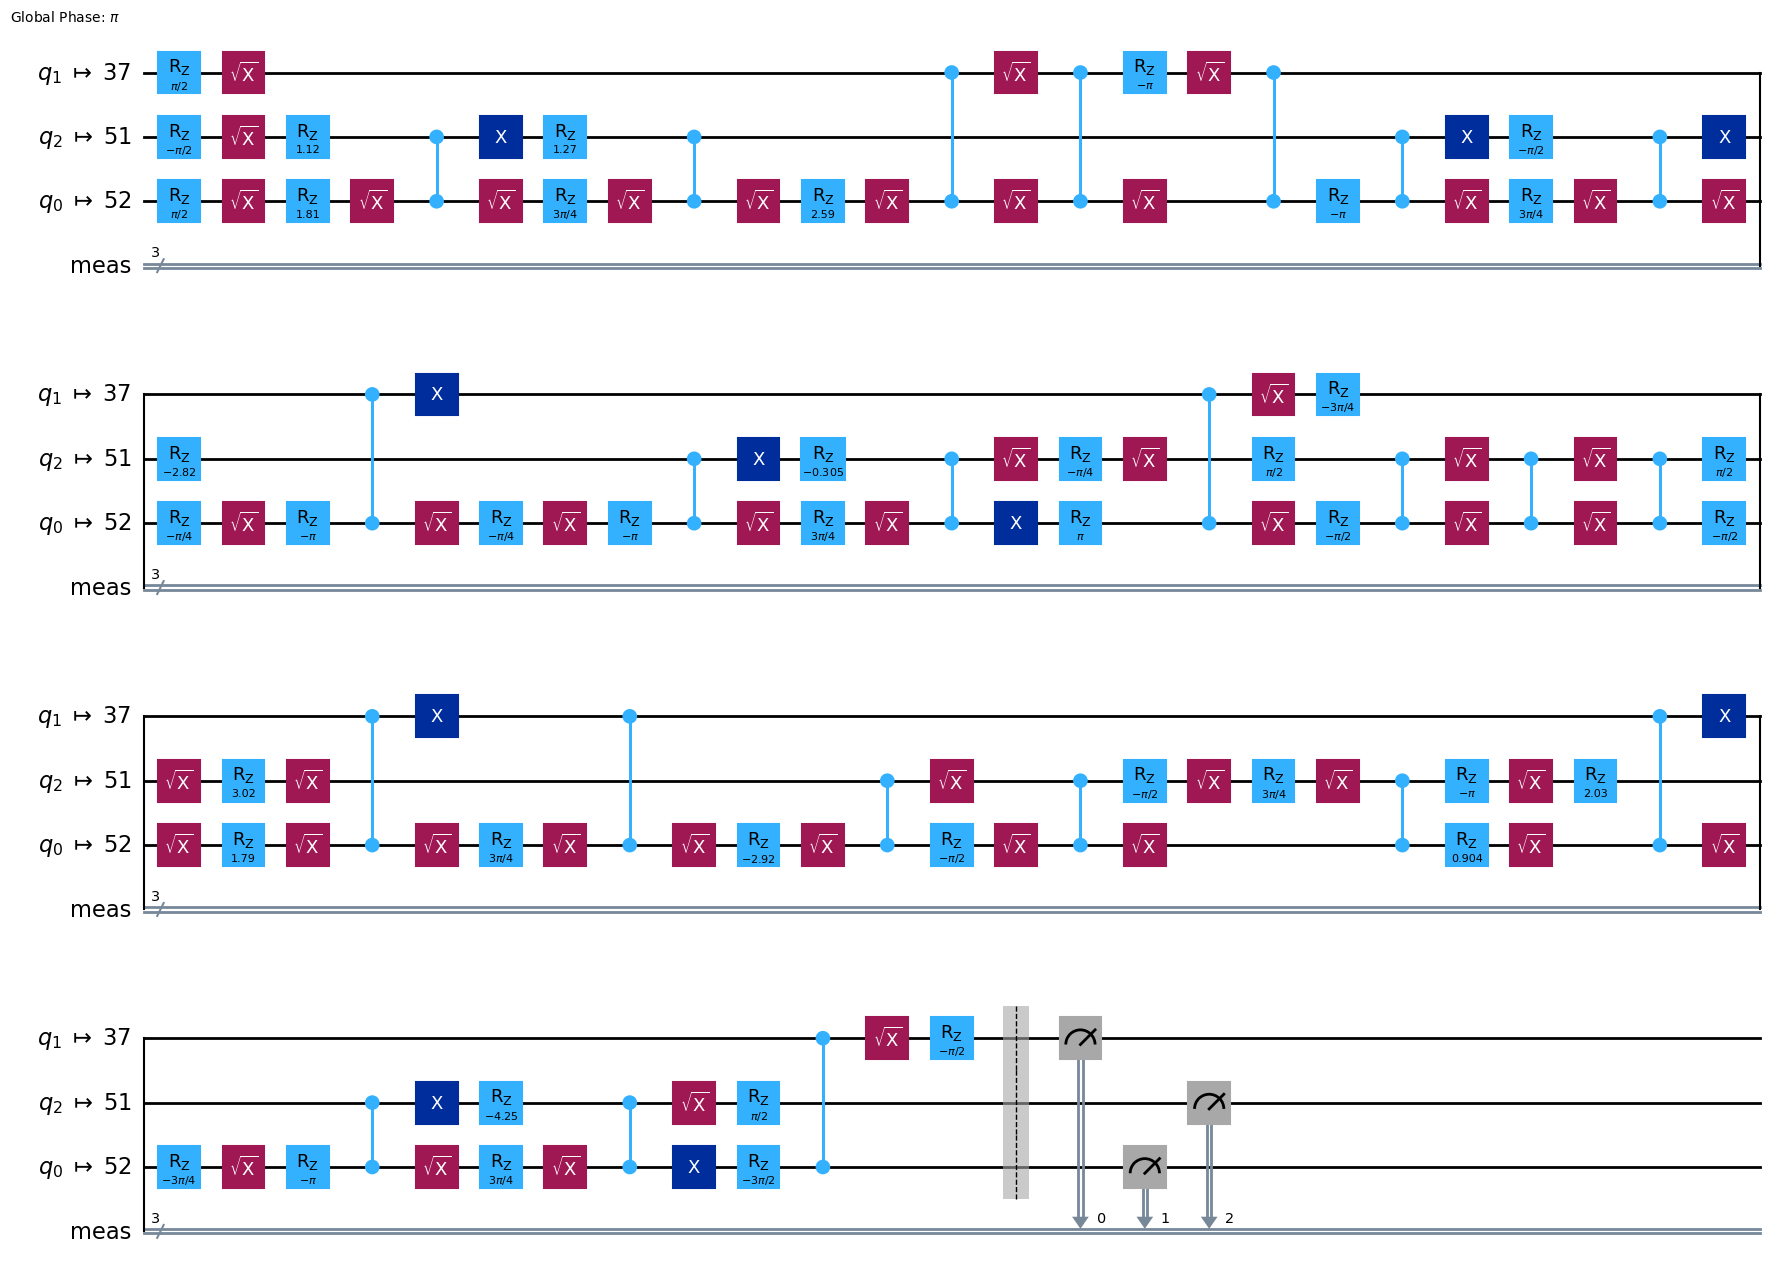

In [26]:
transpiled_qc_cz = pass_manager_cz.run(qc)

In [29]:
result_ecr = simulator.run(transpiled_qc_ecr, noise_model=ecr_noise).result()

In [30]:
for q1 in range(2):
    for q2 in range(2):
        for q3 in range(2):
            transpiled_qc_ecr.reset(0)
            transpiled_qc_ecr.initialize([q1, 1-q1], 0)
            transpiled_qc_ecr.initialize([q2, 1-q2], 1)
            transpiled_qc_ecr.initialize([q3, 1-q3], 2)
            result_ecr = simulator.run(transpiled_qc_ecr, noise_model=ecr_noise).result()
            print(f"initialized {q1}, {q2}, {q3}", result_ecr.get_counts())



initialized 0, 0, 0 {'001': 44, '110': 44, '100': 49, '101': 31, '111': 39, '011': 39, '000': 724, '010': 54}
initialized 0, 0, 1 {'101': 48, '100': 47, '110': 56, '111': 33, '011': 61, '001': 49, '010': 51, '000': 679}
initialized 0, 1, 0 {'110': 38, '101': 46, '100': 52, '111': 49, '011': 44, '001': 54, '010': 39, '000': 702}
initialized 0, 1, 1 {'001': 44, '110': 52, '100': 56, '101': 35, '011': 40, '111': 51, '010': 50, '000': 696}
initialized 1, 0, 0 {'001': 45, '100': 50, '101': 42, '110': 42, '111': 41, '011': 44, '010': 44, '000': 716}
initialized 1, 0, 1 {'100': 38, '101': 34, '001': 46, '110': 41, '111': 40, '011': 46, '010': 46, '000': 733}
initialized 1, 1, 0 {'101': 46, '100': 38, '001': 57, '011': 44, '111': 34, '110': 45, '010': 37, '000': 723}
initialized 1, 1, 1 {'100': 46, '001': 51, '110': 38, '101': 46, '011': 60, '111': 45, '010': 45, '000': 693}


In [31]:
print(qc.depth())
print(transpiled_qc_cz.depth())
print(transpiled_qc_ecr.depth())

30
87
91
